# Завдання №1
Модифікувати функцію HH для впливу вхідного струму довільної форми (замість постійного рівня вхідного струму) та із застосуванням ODE розрахунку моделі (odeint із scipy.integrate).

Застосувати стимуляцію вхідним струмом, вивести на підграфіки вхідний струм і відповідний йому потенціал нейрона

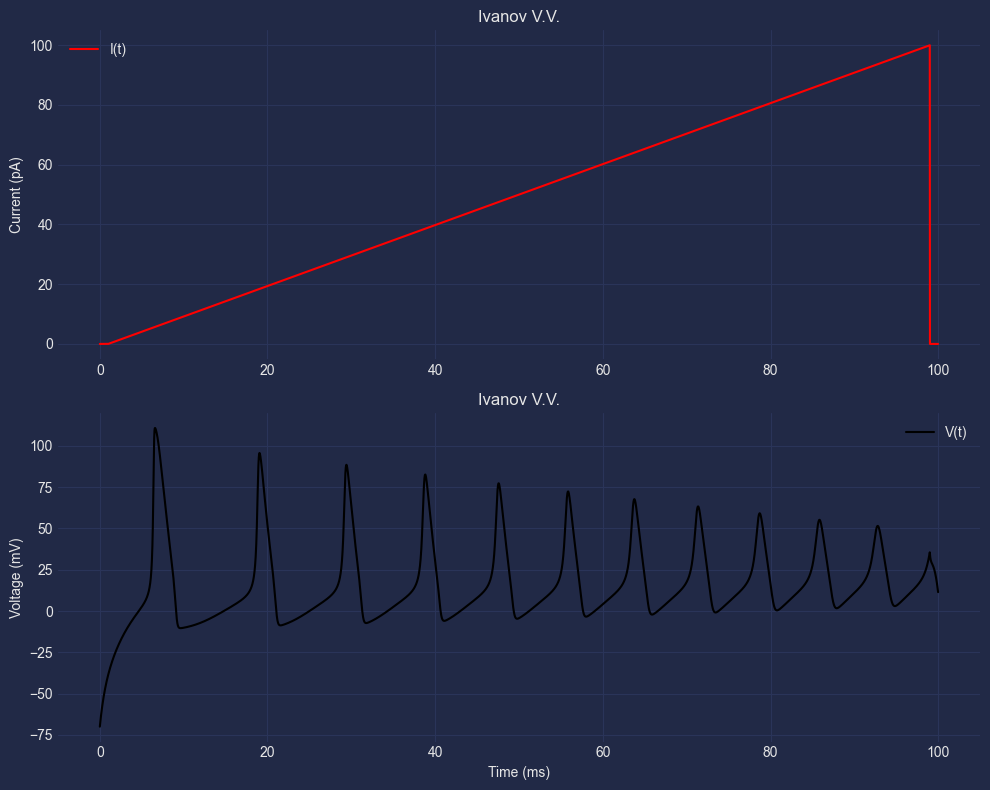

In [9]:
import mplcyberpunk
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.style.use("cyberpunk")

class HodgkinHuxleyModel:
    def __init__(self, T0, dt):
        self.T0 = T0
        self.dt = dt

    def alpha_m(self, V):
        return (2.5 - 0.1 * V) / (np.exp(2.5 - 0.1 * V) - 1)

    def beta_m(self, V):
        return 4 * np.exp(-V / 18)

    def alpha_h(self, V):
        return 0.07 * np.exp(-V / 20)

    def beta_h(self, V):
        return 1 / (np.exp(3 - 0.1 * V) + 1)

    def alpha_n(self, V):
        return (0.1 - 0.01 * V) / (np.exp(1 - 0.1 * V) - 1)

    def beta_n(self, V):
        return 0.125 * np.exp(-V / 80)

    def I_func(self, t):
        if 1 <= t <= (self.T0 - 1):
            return 100 * (t - 1) / (self.T0 - 2)
        return 0

    def HH_model(self, Y, t):
        V, m, h, n = Y
        I = self.I_func(t)
        dV = I - 120 * m ** 3 * h * (V - 115) - 36 * n ** 4 * (V + 12) - 0.3 * (V - 10.6)
        dm = self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
        dh = self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
        dn = self.alpha_n(V) * (1 - n) - self.beta_n(V) * n
        return [dV, dm, dh, dn]

    def simulate(self):
        time = np.arange(0, self.T0, self.dt)
        init_conditions = [-70, 0.05, 0.54, 0.34]
        result = odeint(self.HH_model, init_conditions, time)
        V, m, h, n = result.T
        return V, m, h, n, time

    def plot(self, V, time):
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        plt.plot(time, [self.I_func(t) for t in time], 'r', label="I(t)")
        plt.ylabel('Current (pA)')
        plt.title("Ivanov V.V.")
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(time, V, 'k', label="V(t)")
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (mV)')
        plt.title("Ivanov V.V.")
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    T0 = 100
    dt = 0.01
    model = HodgkinHuxleyModel(T0, dt)
    V, m, h, n, time = model.simulate()
    model.plot(V, time)


# Завдання №2
Вивести на графік ефект "все-або-нічого", оцінити різницю амплітуд подразнення.

Тривалість симуляції 10 мс. Тривалість подразнення нейрона від 0.05 до 0.5 мс, конкретне значення в таблиці.

Peak Amplitude for Stimulus Duration 1: 109.06295078992069 mV
Peak Amplitude for Stimulus Duration 2: 107.01205507978405 mV


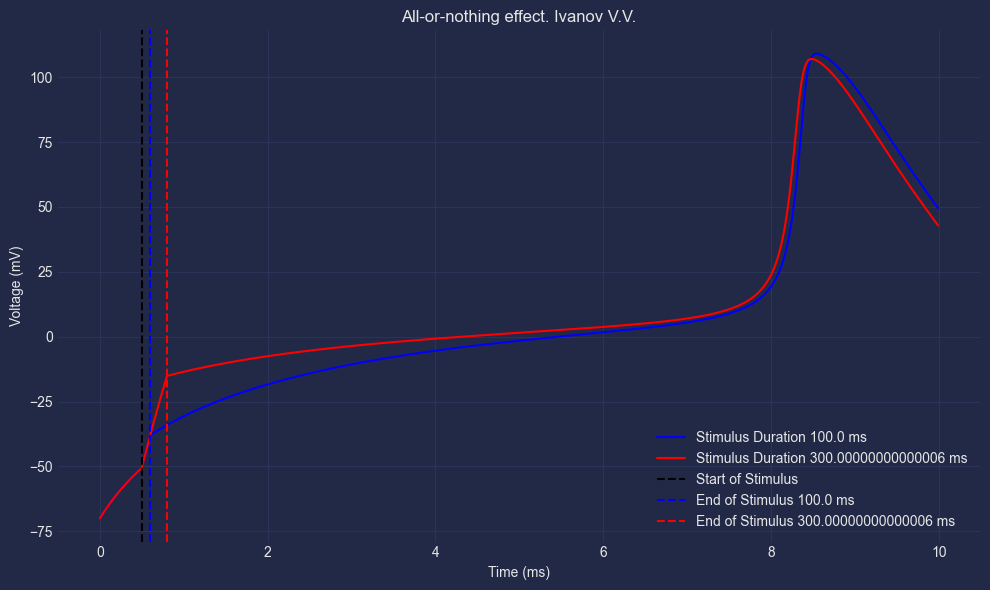

In [10]:
def all_or_nothing_simulation(T0, dt, stimulus_duration):
    model = HodgkinHuxleyModel(T0, dt)

    # Simulate with the first stimulus duration
    model.I_func = lambda t: 100 if (0.5 <= t <= 0.5 + stimulus_duration) else 0
    V1, m, h, n, time = model.simulate()
    peak_amplitude1 = max(V1)  # Peak amplitude of the first response

    # Simulate with the second stimulus duration
    stimulus_duration2 = stimulus_duration + 0.2  # Example: increase by 0.2ms
    model.I_func = lambda t: 100 if (0.5 <= t <= 0.5 + stimulus_duration2) else 0
    V2, m, h, n, time = model.simulate()
    peak_amplitude2 = max(V2)  # Peak amplitude of the second response

    return V1, V2, time, peak_amplitude1, peak_amplitude2

def plot_all_or_nothing(V1, V2, time, stimulus_duration):
    plt.figure(figsize=(10, 6))

    plt.plot(time, V1, 'b', label=f"Stimulus Duration {stimulus_duration*1000} ms")
    plt.plot(time, V2, 'r', label=f"Stimulus Duration {(stimulus_duration+0.2)*1000} ms")

    # Add vertical lines indicating the stimulus duration
    plt.axvline(x=0.5, color='k', linestyle='--', label='Start of Stimulus')
    plt.axvline(x=0.5 + stimulus_duration, color='b', linestyle='--', label=f'End of Stimulus {stimulus_duration*1000} ms')
    plt.axvline(x=0.5 + stimulus_duration + 0.2, color='r', linestyle='--', label=f'End of Stimulus {(stimulus_duration+0.2)*1000} ms')

    plt.ylabel('Voltage (mV)')
    plt.xlabel('Time (ms)')
    plt.title("All-or-nothing effect. Ivanov V.V.")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    T0 = 10
    dt = 0.01
    stimulus_duration = 0.1  # Set the desired stimulus duration
    V1, V2, time, peak_amplitude1, peak_amplitude2 = all_or_nothing_simulation(T0, dt, stimulus_duration)

    print(f"Peak Amplitude for Stimulus Duration 1: {peak_amplitude1} mV")
    print(f"Peak Amplitude for Stimulus Duration 2: {peak_amplitude2} mV")

    plot_all_or_nothing(V1, V2, time, stimulus_duration)